In [10]:
from pytrends.request import TrendReq
import pandas as pd
import matplotlib.pyplot as plt

pytrends = TrendReq(hl='en-US', tz=360)


In [11]:
kw_list = ["Bread","Ferrari"]
pytrends.build_payload(kw_list=kw_list, timeframe=['today 3-m', 'today 3-m'], geo = 'US')
overTime = pytrends.interest_over_time()

/Users/mishangagnon/opt/anaconda3/envs/si206/lib/python3.12/site-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


In [12]:
kw_list = ["food near me"]
pytrends.build_payload(kw_list=kw_list, timeframe=['today 3-m'], geo = 'US')
overTime = pytrends.interest_by_region(resolution='CITY')

/Users/mishangagnon/opt/anaconda3/envs/si206/lib/python3.12/site-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


<Axes: >

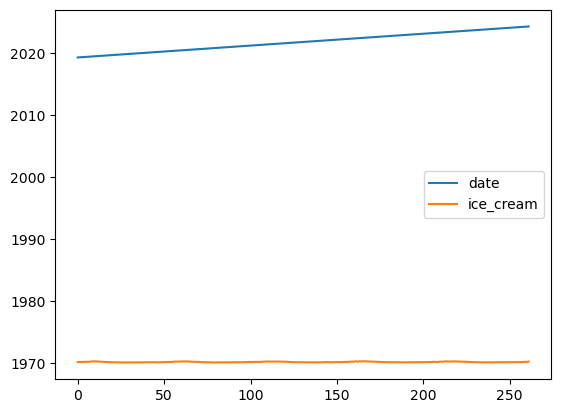

In [13]:
from pytrends.request import TrendReq
import pandas as pd

# Initialize a TrendReq object
pytrend = TrendReq(hl='en-US', tz=360)  # 'hl' is the host language, 'tz' is the timezone offset

# Define the search keyword and the region
keyword = 'ice cream'
geo = 'US-MI-505'  # Michigan, USA as the region, you might need to adjust this for more specific local data

# Build the payload
pytrend.build_payload(kw_list=[keyword], geo=geo, timeframe='today 5-y')  # Adjust timeframe as needed

# Get interest over time
interest_over_time_df = pytrend.interest_over_time()
interest_over_time_df.drop('isPartial', axis =1, inplace=True)
interest_over_time_df = interest_over_time_df.reset_index()
interest_over_time_df.columns = interest_over_time_df.columns.str.replace(' ', '_', regex=True)



# Display the data
interest_over_time_df.plot(kind = 'line')


In [20]:
def set_up_database(db_name):
    conn = sqlite3.connect("/Users/mishangagnon/si206/si206-final-project" + "/" + db_name)
    cur = conn.cursor()
    return conn

def create_table_from_df(df, table_name, conn):
    # Start the CREATE TABLE statement
    sql = f"CREATE TABLE IF NOT EXISTS {table_name} ("
    
    # Add columns with appropriate data types
    columns = []
    for col_name, dtype in df.dtypes.items():
        col_type = 'TEXT'  # Default type
        if pd.api.types.is_integer_dtype(dtype):
            col_type = 'INTEGER'
        elif pd.api.types.is_float_dtype(dtype):
            col_type = 'REAL'
        elif pd.api.types.is_datetime64_any_dtype(dtype):
            col_type = 'DATETIME'
        # Add column specification
        columns.append(f"{col_name} {col_type}")
    
    # Complete the SQL statement
    sql += ", ".join(columns)
    sql += ")"
    
    # Execute the SQL statement
    cur = conn.cursor()
    cur.execute(sql)
    conn.commit()


def get_oldest_date(table_name, date_col_name, conn):

    # Create a cursor object using the connection
    cur = conn.cursor()
    
    # Execute the query to find the oldest date
    cur.execute(f"SELECT MIN({date_col_name}) FROM {table_name}")
    
    # Fetch the result
    result = cur.fetchone()
    
    # Check if the result is not None
    if result and result[0]:
        return result[0]
    else:
        return None

def shift_date(date_str, days):
    """
    Shifts a given date by a specified number of days using pandas.
    
    Parameters:
    date_str (str): The date in 'YYYY-MM-DD' format.
    days (int): The number of days to shift the date. Negative for past, positive for future.
    
    Returns:
    str: The shifted date in 'YYYY-MM-DD' format.
    """
    date = pd.to_datetime(date_str)
    
    # Create a Timedelta and shift the date by the specified number of days
    new_date = date + pd.Timedelta(days=days)
    
    # Convert the Timestamp back to a string in 'YYYY-MM-DD' format
    return new_date.strftime('%Y-%m-%d')

def insert_data_from_df(df, table_name, date_col_name, conn):

    # Create a cursor object using the connection
    cur = conn.cursor()
    df[date_col_name] = pd.to_datetime(df[date_col_name])
    df[date_col_name] = df[date_col_name].dt.strftime('%Y-%m-%d')
    # Prepare the INSERT INTO statement
    placeholders = ', '.join(['?'] * len(df.columns))
    columns = ', '.join(df.columns)
    sql = f"INSERT INTO {table_name} ({columns}) VALUES ({placeholders})"
    # Insert each row from the DataFrame
    for row in df.itertuples(index=False, name=None):
        cur.execute(sql, row)
        conn.commit()
    
    # Commit the transactions

In [16]:
import os
import sqlite3
DB_NAME = "test.db"
TABLE_NAME = "interest_over_time"
conn = set_up_database(DB_NAME)
create_table_from_df(interest_over_time_df, TABLE_NAME, conn)
#insert_data_from_df(interest_over_time_df, TABLE_NAME,'date', conn)

In [17]:
cur = conn.cursor()

# Execute the SELECT query
cur.execute("SELECT * FROM interest_over_time")

# Fetch and print the results
print(cur.fetchall())

[]


In [18]:
from pytrends.request import TrendReq
from db_utils import *
import matplotlib.pyplot as plt
def request_search_range_df(start_date, end_date, query):

    # Initialize a TrendReq object
    pytrend = TrendReq(hl='en-US', tz=360)  # 'hl' is the host language, 'tz' is the timezone offset

    # Define the search keyword and the region
    keyword = query
    geo = 'US-MI-505'  # Michigan, USA as the region, you might need to adjust this for more specific local data

    # Build the payload
    pytrend.build_payload(kw_list=[keyword], geo=geo, timeframe=f'{start_date} {end_date}')  # Adjust timeframe as needed

    # Get interest over time
    interest_over_time_df = pytrend.interest_over_time()
    interest_over_time_df.drop('isPartial', axis =1, inplace=True)
    interest_over_time_df = interest_over_time_df.reset_index()
    interest_over_time_df.columns = interest_over_time_df.columns.str.replace(' ', '_', regex=True)

    return interest_over_time_df

In [22]:
oldest_date = get_oldest_date(TABLE_NAME,'date',conn)
print(oldest_date)


None


In [25]:
pytrends.build_payload(kw_list=['ice cream', 'mets'], timeframe=['2022-09-04 2022-09-10', '2022-09-18 2022-09-24'])
pytrends.multirange_interest_over_time()

,[0] ice cream date,[0] ice cream value,[1] mets date,[1] mets value
0,Average,68,Average,54
1,"Sep 4, 2022",100,"Sep 18, 2022",83
2,"Sep 5, 2022",95,"Sep 19, 2022",28
3,"Sep 6, 2022",55,"Sep 20, 2022",53
4,"Sep 7, 2022",50,"Sep 21, 2022",77
5,"Sep 8, 2022",48,"Sep 22, 2022",28
6,"Sep 9, 2022",51,"Sep 23, 2022",29
7,"Sep 10, 2022",74,"Sep 24, 2022",79


In [ ]:
pytrend = TrendReq(hl='en-US', tz=360)  # 'hl' is the host language, 'tz' is the timezone offset

    # Define the search keyword and the region
keyword = ["ice cream","mets"]
geo = 'US-MI-505'  # Michigan, USA as the region, you might need to adjust this for more specific local data

# Build the payload
pytrend.build_payload(kw_list=keyword, geo=geo, timeframe='2023-08-08 2023-09-01')  # Adjust timeframe as needed

# Get interest over time
interest_over_time_df = pytrend.interest_over_time()
print(interest_over_time_df)

            ice cream  mets  isPartial
date                                  
2022-09-05         97     0      False
2022-09-06         43    19      False
2022-09-07         58    12      False
2022-09-08         53     0      False
2022-09-09         63     0      False
2022-09-10        100    14      False


In [ ]:
new_df.tail()

,date,ice cream
257,2024-03-31,45
258,2024-04-07,58
259,2024-04-14,66
260,2024-04-21,60
261,2024-04-28,80
